In [1]:
import pandas as pd, numpy as np
import os, glob
from mizani.formatters import scientific_format

# Navigate to src directory
#os.chdir("C:/Users/jstelman/Git/chelsvig_urban_pesticides/src/") # when running on Julia's little laptop
os.chdir("C:/Git/chelsvig_urban_pesticides/src/") # when runnning on Julia's big laptop
# save some paths we'll be using
from path_names import *
# redirect vvwm_path to our temporary test data folder instead of the usual folder
vvwm_path = os.path.join(os.path.abspath("../.."),"vvwm")
print(vvwm_path)
# save path to the observed data
obs_path = os.path.join(main_path, "observed_data", "SURF_water_placer_bifenthrin.csv")
print(obs_path)
# save a list of outfalls we'll use to create more paths as we go
outfalls = ['outfall_31_26', 'outfall_31_28', 'outfall_31_29', 'outfall_31_35', 
            'outfall_31_36', 'outfall_31_38', 'outfall_31_42']

main_path   C:\Git\chelsvig_urban_pesticides
dir_path    C:\Git\chelsvig_urban_pesticides\probabilistic_python
exe_path    C:\Git\chelsvig_urban_pesticides\probabilistic_python\exe
swmm_path   C:\Git\chelsvig_urban_pesticides\probabilistic_python\input\swmm
inp_path    C:\Git\chelsvig_urban_pesticides\probabilistic_python\input\swmm\NPlesantCreek.inp
bin_path    C:\Git\chelsvig_urban_pesticides\probabilistic_python\input\swmm\NPlesantCreek.out
vvwm_path   C:\Git\chelsvig_urban_pesticides\probabilistic_python\input\vvwm
wet_path    C:\Git\chelsvig_urban_pesticides\probabilistic_python\weather
C:\Git\vvwm
C:\Git\chelsvig_urban_pesticides\observed_data\SURF_water_placer_bifenthrin.csv


In [2]:
# Import Observed Data
obs_data = pd.read_csv(obs_path, usecols=["Concentration..ppb.","Level_of_quantification..ppb.",
                                         "Method_detection_level..ppb.", "Sample_date", "Site_code"],
                      parse_dates=["Sample_date"])

# do Proxy (meaning that, for concentrations reported as 0, replace them with half the detection minimum to be conservative)
for idx, row in obs_data[obs_data['Concentration..ppb.']==0].iterrows():
    obs_data.loc[idx,'Concentration..ppb.'] = min([row['Level_of_quantification..ppb.'],
                                                   row['Method_detection_level..ppb.']])/2

# drop columns (now that we did the Proxy step, we are done with these)
obs_data = obs_data.drop(labels = ["Level_of_quantification..ppb.","Method_detection_level..ppb."], axis = 1)
obs_data.head()

,Concentration..ppb.,Sample_date,Site_code
0,0.00235,2015-06-08,31_26
1,0.00235,2010-06-24,31_44
2,0.00235,2009-05-06,31_44
3,0.00235,2010-09-03,31_44
4,0.00035,2016-10-14,31_26


## For 112 simulations

In [3]:
# save a list of the 112 inputs we will be referencing as we go
inputs = [os.path.basename(name) for name in glob.glob(os.path.join(vvwm_path, "outfall_31_26", "input_*"))]
# define a function that takes in an outfall and an input and constructs a path to their pertaining simmulation's output file
def output_path2(of, ip):
    op_path = os.path.join(vvwm_path, of, ip, "output_NPlesant_Custom_parent_daily.csv")
    return(op_path)

In [4]:
# Want to loop through the simulations to calculate and save their NSEs

# initialize a list to stow them in
NSEs = []

for i in inputs:
    # Load the data for each simulation, i, into a df; start by doing this for outfall = "outfall_31_26"
    
    # We only care about the column, "davg_bif_conc" (scale by 1,000,000 to sync simulated and observed data units)
    simi_of26_data = pd.read_csv(output_path2("outfall_31_26", i), usecols = [1], skiprows=5, names = ["davg_bif_conc"])*1000000
    # We'll also need 2 more columns before we can line up the simulation data up with the observations accurately
    simi_of26_data['Sample_date'] = pd.date_range(start='1/1/2009', periods=3287, freq='D')
    simi_of26_data['Site_code'] = '31_26'
    # Now we can join the simulated and observed dataframes to each other by date and location to create the df, comp_data_ipi
    comp_data_ipi = simi_of26_data.merge(obs_data, how = "inner", on = ['Sample_date','Site_code'])
    
    # Now continue the process for all the other outfalls
    for of in outfalls[1:]:
        dat = pd.read_csv(output_path2(of, i), usecols = [1], skiprows=5, names = ["davg_bif_conc"])*1000000
        dat['Sample_date'] = pd.date_range(start='1/1/2009', periods=3287, freq='D')
        dat['Site_code'] = of[-5:]
        # append the resulting rows to build upon comp_data_ipi with each outfall
        comp_data_ipi = comp_data_ipi.append(
            dat.merge(obs_data, how = "inner", on = ['Sample_date','Site_code']), ignore_index=True)
    # perform the NSE calculation for simulation i using the df we just finished building, comp_data_ipi
    NSEi = 1 - ((sum(comp_data_ipi['davg_bif_conc'] - comp_data_ipi['Concentration..ppb.'])**2)/
                (sum(comp_data_ipi['Concentration..ppb.'] - sum(comp_data_ipi['Concentration..ppb.'])/
                     len(comp_data_ipi['Concentration..ppb.']))**2))
    # append the NSE of simulation i to the list of NSEs
    NSEs.append(NSEi)

In [5]:
# What do  we got?
NSEs
# Wow, these are all terrrrible

[-4.066021452443556e+54,
 -3.8599171755554547e+55,
 -2.206865728774752e+55,
 -2.2277674345547663e+55,
 -2.805538927482503e+54,
 -3.114161955127447e+54,
 -2.3069616075356395e+55,
 -2.9590266780416298e+54,
 -5.06800584567615e+54,
 -3.844067985368535e+54,
 -1.6847766751798336e+54,
 -7.978032285166373e+54,
 -1.8163983425407886e+55,
 -7.285010369869462e+54,
 -7.60846173096257e+54,
 -1.5446682050824052e+55,
 -1.0603705802402675e+55,
 -1.482395214375138e+55,
 -2.8490193639871263e+55,
 -3.4291274237991697e+55,
 -2.880486167015523e+55,
 -3.6680463343217095e+55,
 -2.2470001060234823e+55,
 -2.3895474501135302e+55,
 -7.020247123497176e+54,
 -6.560355149031143e+55,
 -9.993974439664223e+54,
 -2.478859552288944e+55,
 -2.389485197758379e+55,
 -2.49074600871382e+55,
 -5.49295390944757e+54,
 -1.8077580119808113e+55,
 -3.471613548673933e+54,
 -2.369169900570354e+55,
 -1.3245177930333755e+55,
 -2.7091995670743287e+54,
 -1.5903039872501029e+55,
 -1.5481287591584148e+55,
 -1.4423894379556296e+54,
 -8.744759

### Get LHS data pertaining to "best" NSEs

In [6]:
# save the rows of the Latin Hypercube Sampled parameter datafile pertaining to the 112 simulations we're using today
# For the SWMM stage 
swmm_df = pd.read_csv(os.path.join(vvwm_path, "lhs_params", "lhs_sampled_params.csv"), index_col=0
                     ).iloc[[int(inputs[i][6:]) - 1 for i in range(len(inputs))]]
# For  the VVWM stage
vvwm_df = pd.read_csv(os.path.join(vvwm_path, "lhs_params", "lhs_sampled_params_vvwm.csv"), index_col=0
                     ).iloc[[int(inputs[i][6:]) - 1 for i in range(len(inputs))]]

In [7]:
# define function to abridge the data frames to just the rows with NSEs in the top p%-tile
def subset_lhs_data(acc_rate, vvwm = False):
    # how many rows be in subseted dataframe? 
    if acc_rate == 1:
        n_acc = 0
    elif acc_rate < 1 and acc_rate > 0:
        n_acc = int(np.ceil(len(inputs)*acc_rate))
    else:
        # make sure the accuracy rate is actually a number between 1 and 0
        print("acc_rate not in (0,1].")
        return None
    # which rows will make the cut?
    sbst = [int(inputs[i][6:]) - 1 for i in sorted(range(len(NSEs)), key=lambda i: NSEs[i])[(0-n_acc):]]
    # which model's data are we performing this operation on?
    lhsp = vvwm_df if vvwm else swmm_df
    
    # do it! (subset and return to just those pertaining to the winners)
    subset_lhs = lhsp.loc[sbst]
    return(subset_lhs)

### First the SWMM side

In [8]:
# get params of top 25% of Nash-Sutcliffe Efficiencies, in this case, 28
swmm_df_25 = subset_lhs_data(.25, False)
# get params of top 10% of Nash-Sutcliffe Efficiencies, in this case, 12
swmm_df_10 = subset_lhs_data(.1, False)
# get params of top 5% of Nash-Sutcliffe Efficiencies, in this case, 6
swmm_df_05 = subset_lhs_data(.05, False)

### Then the vvwm side

In [9]:
# get details of top 25% of Nash-Sutcliffe Efficiencies, in this case, 28
vvwm_df_25 = subset_lhs_data(.25, True)
# get details of top 10% of Nash-Sutcliffe Efficiencies, in this case, 12
vvwm_df_10 = subset_lhs_data(.1, True)
# get details of top 5% of Nash-Sutcliffe Efficiencies, in this case, 6
vvwm_df_05 = subset_lhs_data(.05, True)

### Prepare data for plotting

#### Stack and concat 4 variations of SWMM data

In [20]:
# Start with the full dataframe, and then do the subsetted ones
swmm_100 = pd.DataFrame(swmm_df.stack()).reset_index(level=[1])
# assign meaningful column labels (will use parameter for faceting)
swmm_100.columns = ["parameter","value"]
# add another column for acceptance rate (will use for linetype)
swmm_100["acc_rate"] = " all"

# Do the same for 3 subsetted data frames
swmm_25 = pd.DataFrame(swmm_df_25.stack()).reset_index(level=[1])
swmm_25.columns = ["parameter","value"]
swmm_25["acc_rate"] = "25%"

swmm_10 = pd.DataFrame(swmm_df_10.stack()).reset_index(level=[1])
swmm_10.columns = ["parameter","value"]
swmm_10["acc_rate"] = "10%"

swmm_05 = pd.DataFrame(swmm_df_05.stack()).reset_index(level=[1])
swmm_05.columns = ["parameter","value"]
swmm_05["acc_rate"] = "05%"

# Concatenate all 4 results into one
swmm_MULTI = pd.concat([swmm_100, swmm_25, swmm_10, swmm_05])

#### Stack and concat 4 variations of VVWM data

In [21]:
# Do the same for vvwm
vvwm_100 = pd.DataFrame(vvwm_df.stack()).reset_index(level=[1])
vvwm_100.columns = ["parameter","value"]
vvwm_100["acc_rate"] = " all"

vvwm_25 = pd.DataFrame(vvwm_df_25.stack()).reset_index(level=[1])
vvwm_25.columns = ["parameter","value"]
vvwm_25["acc_rate"] = "25%"

vvwm_10 = pd.DataFrame(vvwm_df_10.stack()).reset_index(level=[1])
vvwm_10.columns = ["parameter","value"]
vvwm_10["acc_rate"] = "10%"

vvwm_05 = pd.DataFrame(vvwm_df_05.stack()).reset_index(level=[1])
vvwm_05.columns = ["parameter","value"]
vvwm_05["acc_rate"] = "05%"

vvwm_MULTI = pd.concat([vvwm_100, vvwm_25, vvwm_10, vvwm_05])

#### Concat SWMM data with VVWM data

In [22]:
# Concatenate the one from SWMM with the one from VVWM
# Add another column for model (will use for color)
sv_MULTI = pd.concat([swmm_MULTI.assign(model = "SWMM"), vvwm_MULTI.assign(model = "VVWM")])

### Histograms and Density Plots

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Histograms

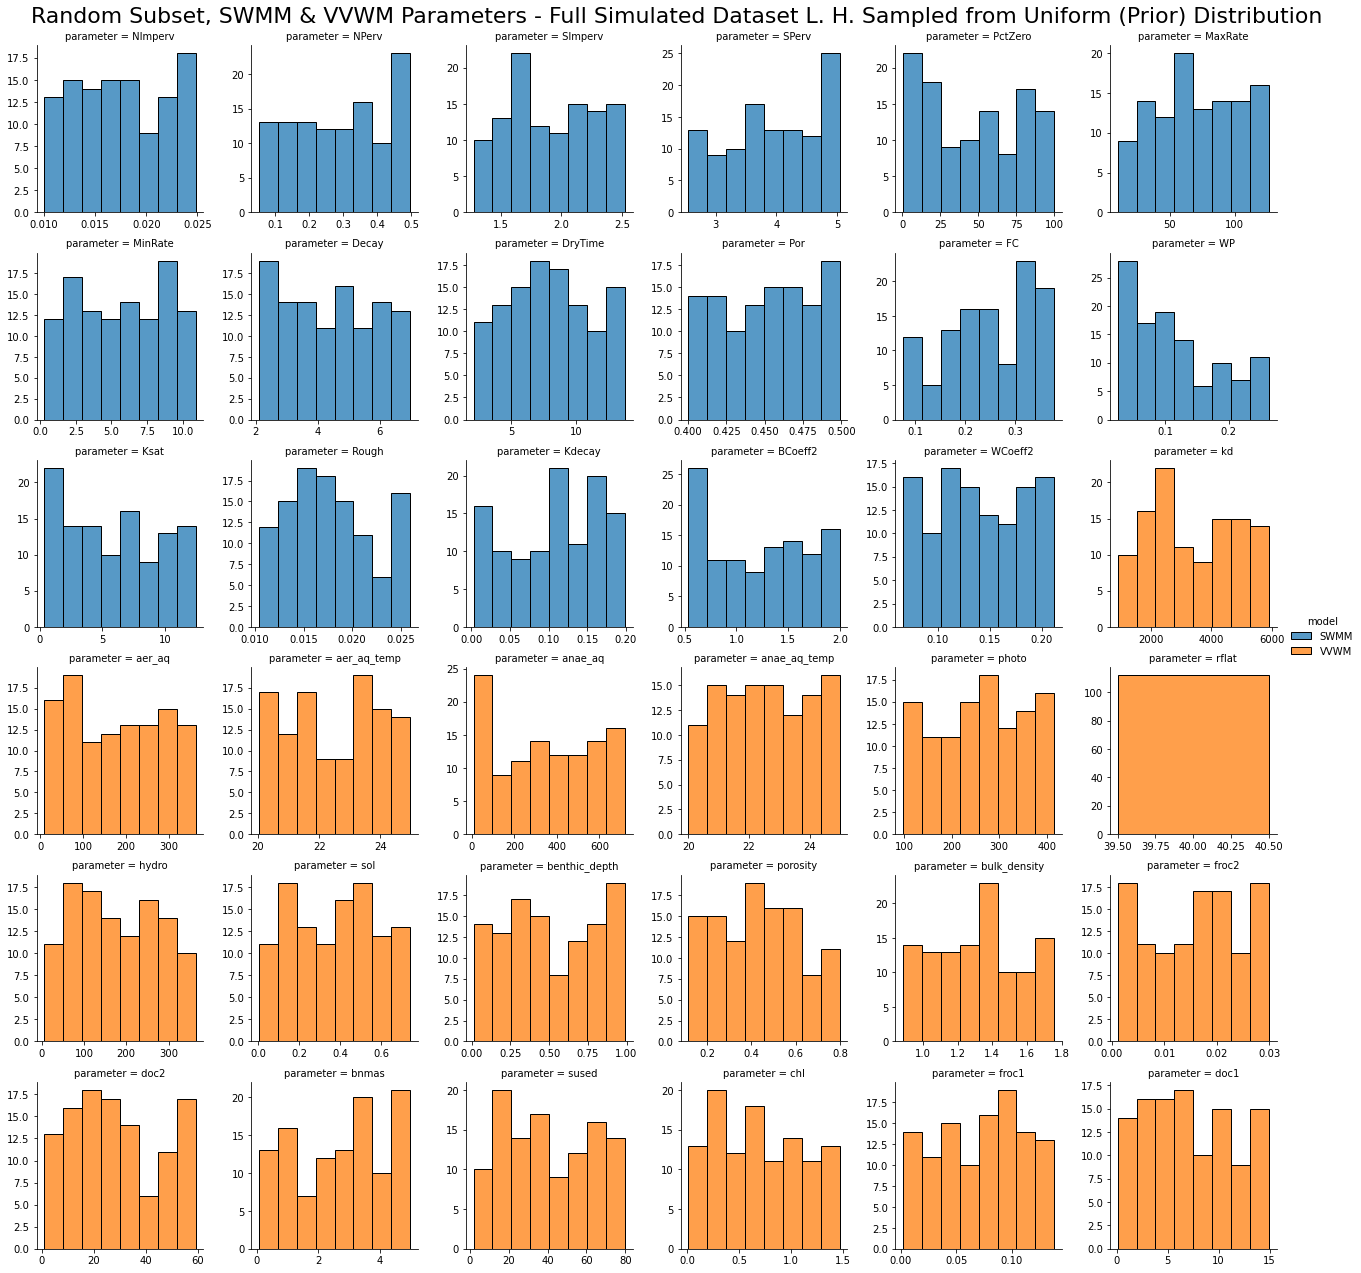

In [14]:
# Make a histogram of parameter values from unabridged dataframe for each of the 36 SWMM & VVWM parameters
# Facet by parameter; color by model
g = sns.FacetGrid(pd.concat([swmm_100.assign(model = "SWMM"), vvwm_100.assign(model = "VVWM")]), 
                  col = "parameter", col_wrap = 6, sharex = False, sharey = False, hue = "model")
g.map_dataframe(sns.histplot, x="value")
# Add legend and title
g.add_legend()
# source: <https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot>
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Random Subset, SWMM & VVWM Parameters - Full Simulated Dataset L. H. Sampled from Uniform (Prior) Distribution",
              fontsize=22)
None

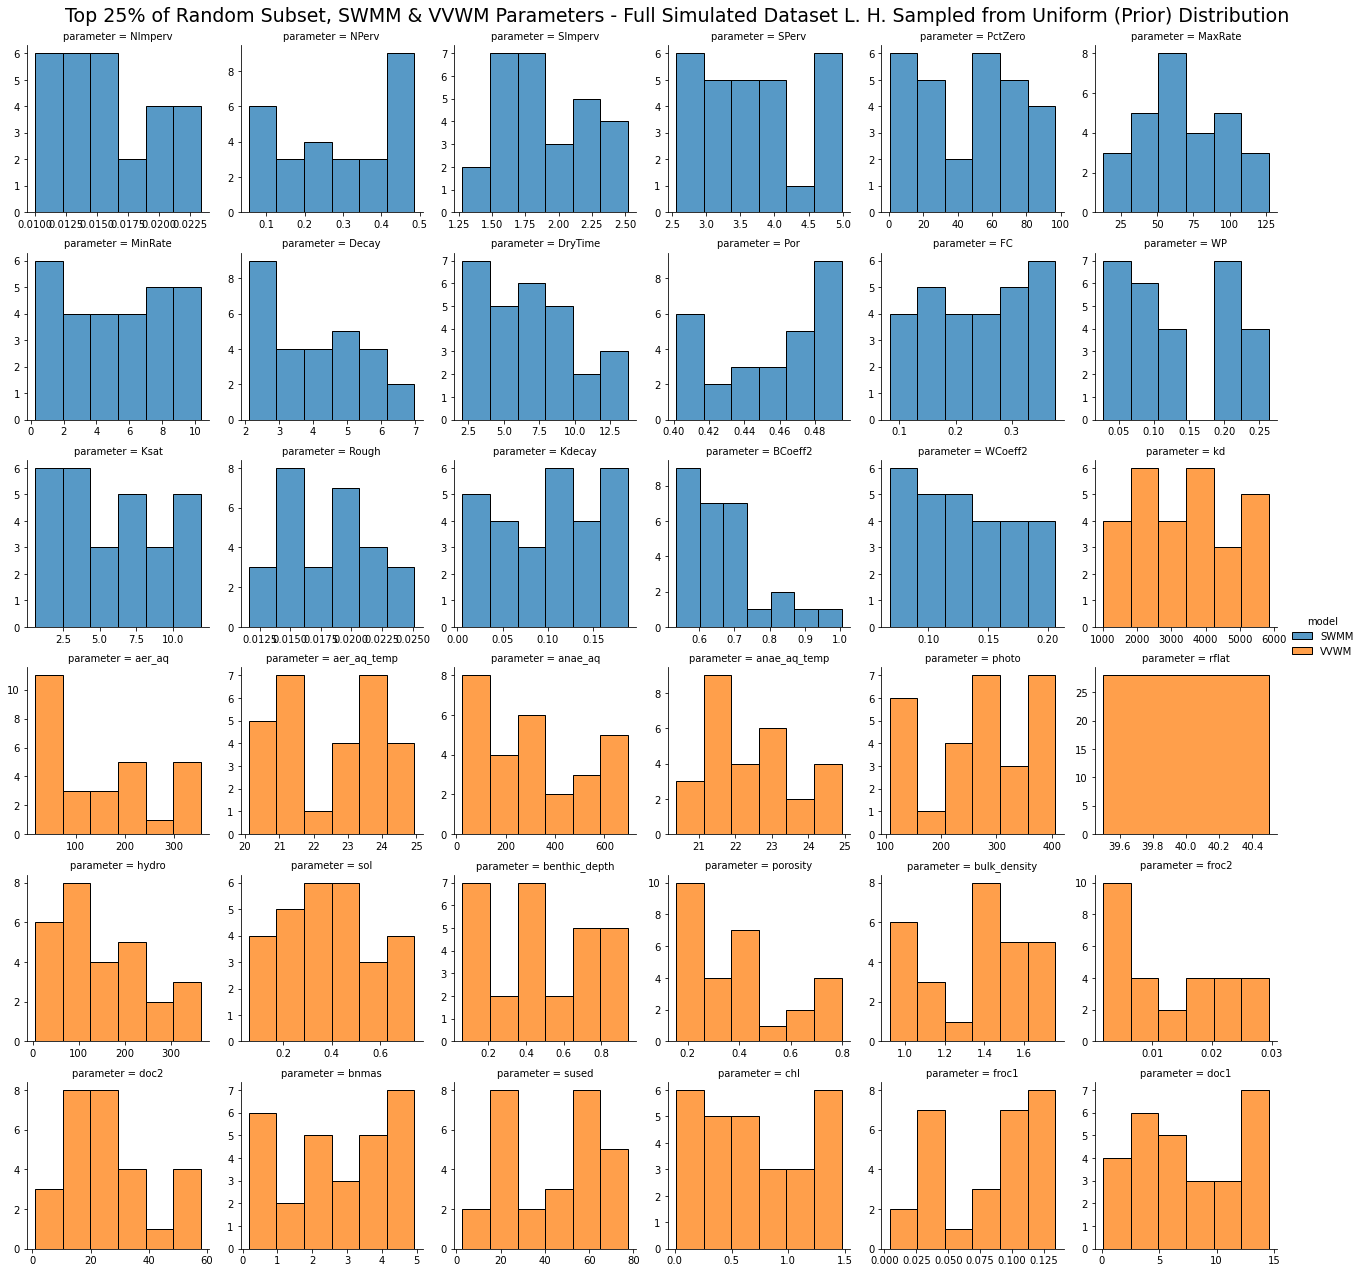

In [15]:
# Do the same for top 25% dataframe
g = sns.FacetGrid(pd.concat([swmm_25.assign(model = "SWMM"), vvwm_25.assign(model = "VVWM")]), 
                  col = "parameter", col_wrap = 6, sharex = False, sharey = False, hue = "model")
g.map_dataframe(sns.histplot, x="value")
g.add_legend()
# source: <https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot>
plt.subplots_adjust(top=0.95)
g.fig.suptitle(
    "Top 25% of Random Subset, SWMM & VVWM Parameters - Full Simulated Dataset L. H. Sampled from Uniform (Prior) Distribution",
    fontsize=19)
None

#### Density Plots

##### Plotnine

In [16]:
import plotnine as p9

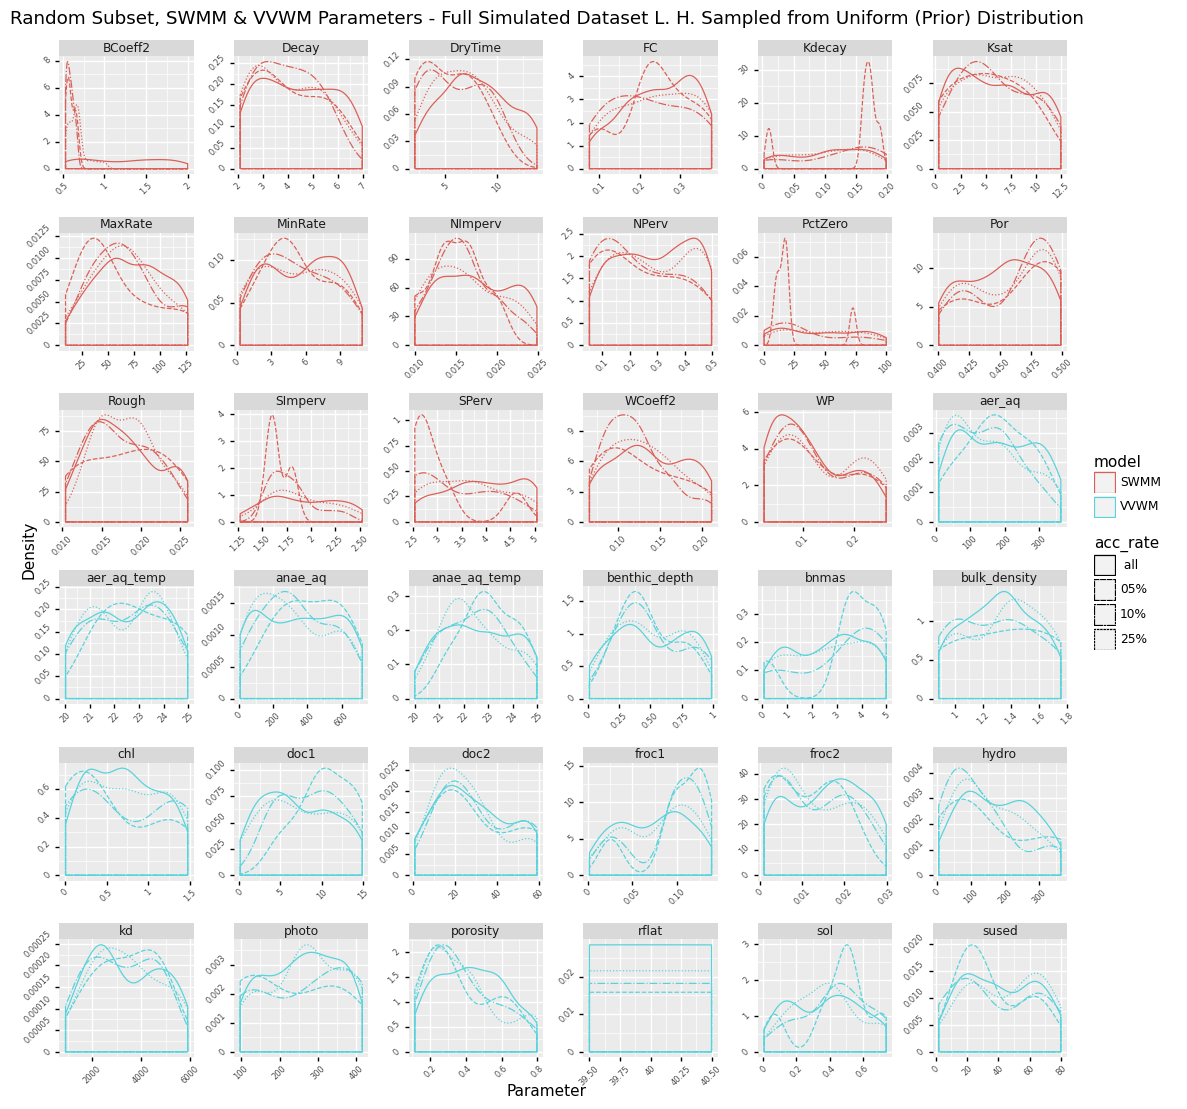

<ggplot: (138642331269)>

In [23]:
# Plot density plots of parameter values for all of the subsets of dataframes for both models' parameters
(
    # color by model; assign linetype by accuracy rate
    p9.ggplot(sv_MULTI, p9.aes(x = "value", color = "model", linetype = "acc_rate"))
    # facet by parameter
    + p9.facet_wrap("~parameter", scales = "free")
    + p9.geom_density()
    + p9.labs(
        x = "Parameter",  y = "Density",
        title="Random Subset, SWMM & VVWM Parameters - Full Simulated Dataset L. H. Sampled from Uniform (Prior) Distribution",
    )
    # make adjustments to theme so figures and text all fit and nothing overlaps
    + p9.theme(subplots_adjust = {'wspace': 0.3, 'hspace': 0.5},
               axis_text = p9.element_text(angle = 45, size = 6),
               figure_size = (13,13)
              )
)

##### Seaborn

In [ ]:
# Depreciated

g = sns.FacetGrid(sv_MULTI, col = "parameter", col_wrap = 6, sharex = False, sharey = False, hue = "model")
g.map_dataframe(sns.kdeplot, x="value", common_norm=True, hue = "acc_rate") #, linestyle = sv_linestyle) # Doesn't work
g.add_legend()
# source: <https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot>
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Random Subset, SWMM & VVWM Parameters - Full Simulated Dataset L. H. Sampled from Uniform (Prior) Distribution",
              fontsize=22)
None


#### Scatterplots

##### Plotnine

In [18]:
# make a dataframe to create a scatter plot from
# turn the column names into factors (will use for faceting)
# add column for NSEs (will use for y axes)
# add column for model label (will use for marker shape)
sv_sctr_df = pd.concat([swmm_df, vvwm_df], axis = 1
                      ).stack().reset_index(level=[1]
                                           ).assign(NSE = NSEs*36
                                                   ).assign(model = (["SWMM"]*17 + ["VVWM"]*19)*len(inputs))
sv_sctr_df.columns = ["parameter","value","NSE","model"]
# add a column for if NSE is in 25% acceptance region called verdict (will use for marker color)
sv_sctr_df = sv_sctr_df.assign(verdict = lambda x: 
                               list(map(lambda y: 
                                        {True:"accept", False:"reject"}[y], x.NSE > np.quantile(x.NSE,.75))))

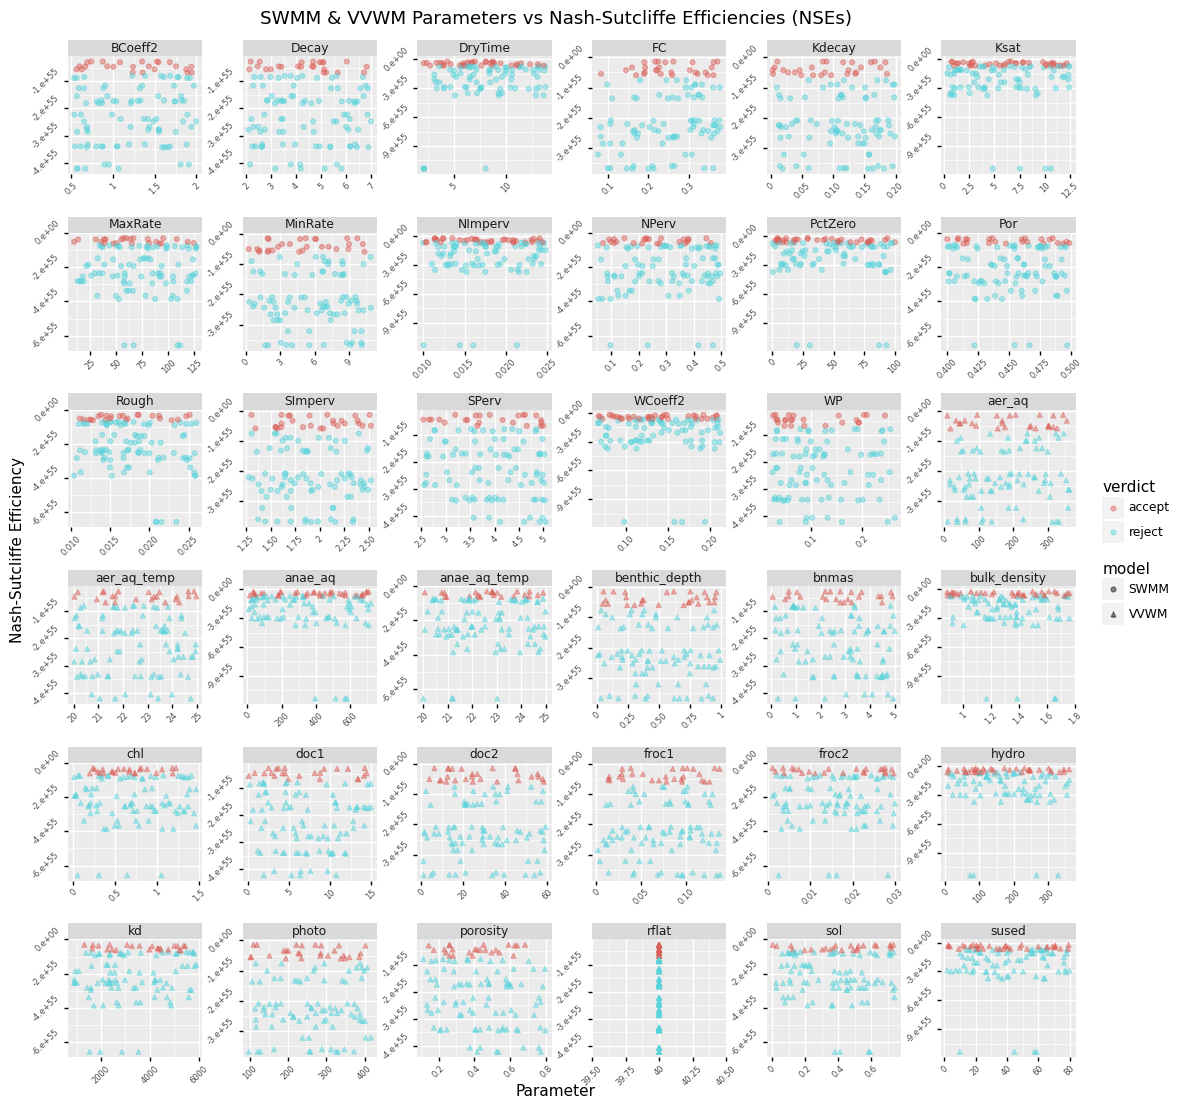

<ggplot: (138518038203)>

In [19]:
# Plot scatter plots of parameter values vs NSEs
(
    # plot parameter value against NSE value; assign marker shape by model
    p9.ggplot(sv_sctr_df, p9.aes(x = "value", y = "NSE", shape = "model"))
    # facet by parameter
    + p9.facet_wrap("~parameter", scales = "free")
    # color by verdict (use 25% acceptance rate)
    + p9.geom_point(p9.aes(color = "verdict"), alpha = 0.45)
    + p9.labs(
        x = "Parameter",  y = "Nash-Sutcliffe Efficiency",
        title="SWMM & VVWM Parameters vs Nash-Sutcliffe Efficiencies (NSEs)",
    )
    + p9.theme(subplots_adjust = {'wspace': 0.3, 'hspace': 0.5},
               axis_text = p9.element_text(angle = 45, size = 6),
               figure_size = (13,13)
              )
    # set label format to scientific format so the really long numbers don't stretch across the whole figure
    + p9.scale_y_continuous(labels = scientific_format(digits = 2))
)
